In [ ]:
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 22.7 MB 1.5 MB/s 


In [ ]:
!gdown "https://drive.google.com/uc?id=1ihzKOkYrOIrN3D4vUfXrOdDyRpekHfwP&confirm=t"
!gdown "https://drive.google.com/uc?id=137zOUqUpFFwYGFFpiXEfsAxkGBqUoL8f&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1ihzKOkYrOIrN3D4vUfXrOdDyRpekHfwP&confirm=t
To: /content/05.4_combined_2D_set_without_stereochemistry.sd.xz
100% 417M/417M [00:04<00:00, 94.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=137zOUqUpFFwYGFFpiXEfsAxkGBqUoL8f&confirm=t
To: /content/05.4_combined_set_without_stereochemistry.tsv.xz
100% 742M/742M [00:05<00:00, 124MB/s]


In [ ]:
!gdown "https://drive.google.com/uc?id=1FiIe5vytjf5aUkmuvwRAMBHxvZIbhgML&confirm=t"
!gdown "https://drive.google.com/uc?id=1KHjl5uZ8cBjUg50IKbBf8qp07gglqVoh&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1FiIe5vytjf5aUkmuvwRAMBHxvZIbhgML&confirm=t
To: /content/05.5_combined_2D_set_without_stereochemistry.sd.xz
100% 400M/400M [00:04<00:00, 84.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1KHjl5uZ8cBjUg50IKbBf8qp07gglqVoh&confirm=t
To: /content/05.5_combined_set_without_stereochemistry.tsv.xz
100% 719M/719M [00:08<00:00, 80.8MB/s]


In [ ]:
import lzma
from time import perf_counter
import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange
from rdkit import Chem, SimDivFilters
from rdkit.Chem import rdMolDescriptors, rdmolfiles

In [ ]:
ChEMBL_connectivities = sources[sources.source.str.contains('ChEMBL30')].connectivity.unique()

In [ ]:
sources = pd.concat([chunk for chunk in tqdm(pd.read_csv('05.5_combined_set_without_stereochemistry.tsv.xz', sep='\t', usecols=['connectivity', 'source'], chunksize=1000000), total=60)])
ChEMBL_connectivities = sources[sources.source.str.contains('ChEMBL30')].connectivity.unique()
ExCAPE_connectivities = sources[sources.source.str.contains('ExCAPE-DB')].connectivity.unique()
Sharma_connectivities = sources[sources.source.str.contains('Sharma2016')].connectivity.unique()
Klaeger_connectivities = sources[sources.source.str.contains('Klaeger2017')].connectivity.unique()
Merget_connectivities = sources[sources.source.str.contains('Merget2017')].connectivity.unique()
Christmann_connectivities = sources[sources.source.str.contains('Christmann2016')].connectivity.unique()

# Get connectivities
with lzma.open('05.5_combined_2D_set_without_stereochemistry.sd.xz') as fh, Chem.ForwardSDMolSupplier(fh) as supplier, Chem.rdmolfiles.SDWriter('common_molecules.sdf') as oh:
    connectivities = [mol.GetProp('connectivity') for mol in tqdm(supplier, total=1268606)]
connectivities = pd.DataFrame(connectivities, columns=['connectivity'])

# Identify molecules in all sets
common_connectivities = []
with open('common_connectivities.txt', 'w') as oh:
    for x in Klaeger_connectivities:
        if x in Christmann_connectivities and x in Merget_connectivities and x in Sharma_connectivities and x in ExCAPE_connectivities and x in ChEMBL_connectivities:
            oh.write(x)
            oh.write('\n')
            common_connectivities.append(x)

with lzma.open('05.5_combined_2D_set_without_stereochemistry.sd.xz') as fh, Chem.ForwardSDMolSupplier(fh) as supplier, Chem.rdmolfiles.SDWriter('common_molecules.sdf') as oh:
    for mol in tqdm(supplier, total=1268606):
        if mol.GetProp('connectivity') in common_connectivities:
            oh.write(mol)

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1268606 [00:00<?, ?it/s]

  0%|          | 0/1268606 [00:00<?, ?it/s]

# For molecules in common

In [ ]:
with rdmolfiles.ForwardSDMolSupplier('common_molecules.sdf') as supplier:
    mols = [mol for mol in supplier if mol is not None]
len(mols)

55

In [ ]:
fps = [rdMolDescriptors.GetMorganFingerprintAsBitVect(mol=mol, radius=2, nBits=1024) for mol in mols]
len(fps)

55

In [ ]:
lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
ids = list(lp.LazyBitVectorPick(fps, len(fps), 0.65))

In [ ]:
clustered_common_connectivities = [mol.GetProp('connectivity') for mol in np.array(mols)[ids]]
len(clustered_common_connectivities)

47

In [ ]:
from rdkit.DataManip.Metric import GetTanimotoSimMat
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
simmat = GetTanimotoSimMat(fps)

In [ ]:
def tri2mat(tri_arr):
    n = len(tri_arr)
    m = int((np.sqrt(1 + 4 * 2 * n) + 1) / 2)
    arr = np.ones([m, m])
    for i in range(m):
        for j in range(i):
            arr[i][j] = tri_arr[i + j - 1]
            arr[j][i] = tri_arr[i + j - 1]
    return arr
simmat = tri2mat(simmat)

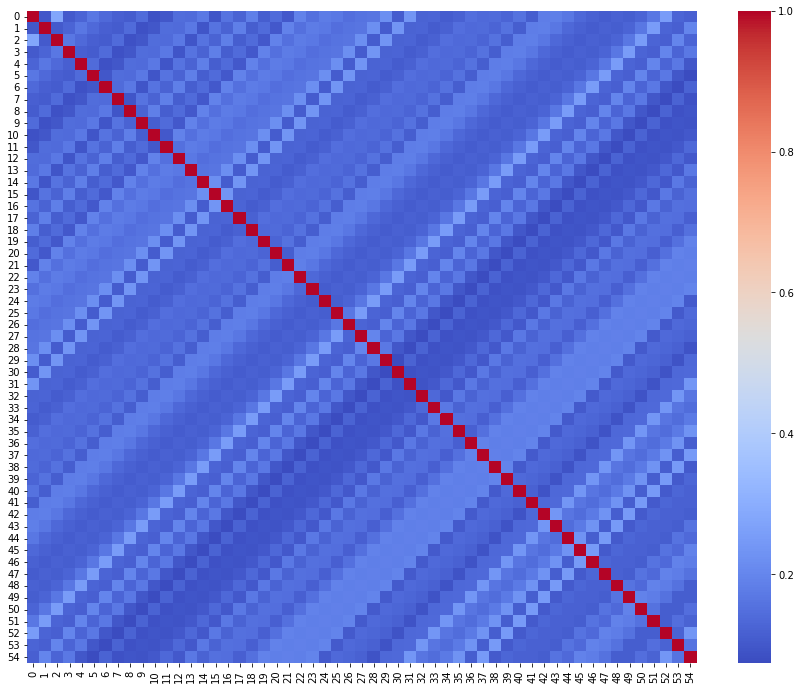

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(simmat, cmap=sns.color_palette("coolwarm", as_cmap=True))

# Seed diversity picker from diverse set of molecules common to all sets

In [ ]:
connectivities['ChEMBL'] = connectivities.connectivity.isin(ChEMBL_connectivities).astype(np.int8)
connectivities['ExCAPE'] = connectivities.connectivity.isin(ExCAPE_connectivities).astype(np.int8)
connectivities['Sharma'] = connectivities.connectivity.isin(Sharma_connectivities).astype(np.int8)
connectivities['Klaeger'] = connectivities.connectivity.isin(Klaeger_connectivities).astype(np.int8)
connectivities['Merget'] = connectivities.connectivity.isin(Merget_connectivities).astype(np.int8)
connectivities['Christmann'] = connectivities.connectivity.isin(Christmann_connectivities).astype(np.int8)

In [ ]:
# Get ids in table of common connectivities
common_conn_ids = connectivities[connectivities.iloc[:, 1:].sum(axis=1) == 6].index.tolist()

In [ ]:
fps = []
with lzma.open('05.5_combined_2D_set_without_stereochemistry.sd.xz') as fh, rdmolfiles.ForwardSDMolSupplier(fh) as supplier:
    for mol in tqdm(supplier, total=1268606):
        fps.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol=mol, radius=2, nBits=1024))
connectivities['FP'] = fps
del fps

  0%|          | 0/1268606 [00:00<?, ?it/s]

In [ ]:
RANDOM = True
if RANDOM:
    connectivities = connectivities.sample(frac=1, random_state=1234).reset_index(drop=True)

In [ ]:
for 

In [ ]:
%%time
lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
id2s = list(lp.LazyBitVectorPick(fps, len(fps), 0.65, firstPicks=ids))

CPU times: user 20min 28s, sys: 8.73 s, total: 20min 37s
Wall time: 20min 28s


In [ ]:
len(id2s), len(fps), len(id2s) / len(fps)

(41154, 1268606, 0.032440332144101476)

In [ ]:
with open('cluster_centers.txt', 'w') as oh:
    oh.write('\n'.join(str(x) for x in id2s))

In [ ]:
for indices in [ChEMBL_indices, ExCAPE_indices, Sharma_indices, Merget_indices, Christmann_indices, Klaeger_indices]:
    lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
    # Keep FPs of subset
    fps_ = [fps[i] for i in tqdm(indices, leave=False)]
    # Identify indices of common structures
    connectivities_ = connectivities.connectivity.loc[indices].reset_index(drop=True)
    seed_connectivities = connectivities_[connectivities_.isin(clustered_common_connectivities)].index.tolist()
    connectivities_ = connectivities_.tolist()
    start = perf_counter()
    ids_ = list(lp.LazyBitVectorPick(fps_, len(fps_), 0.65, firstPicks=seed_connectivities))
    stop = perf_counter()
    print(len(ids_), len(fps_), len(ids_) / len(fps_), stop - start)

  0%|          | 0/936974 [00:00<?, ?it/s]

34091 936974 0.03638414726555913 802.093178178


  0%|          | 0/657571 [00:00<?, ?it/s]

25749 657571 0.03915774874500244 504.1011506719997


  0%|          | 0/38894 [00:00<?, ?it/s]

1503 38894 0.038643492569548 2.60744178799996


  0%|          | 0/1681 [00:00<?, ?it/s]

512 1681 0.3045806067816776 0.028887462000056985


  0%|          | 0/1667 [00:00<?, ?it/s]

556 1667 0.33353329334133175 0.048783799999910116


  0%|          | 0/228 [00:00<?, ?it/s]

158 228 0.6929824561403509 0.0017093980004574405


In [ ]:
for indices in [Klaeger_indices, Christmann_indices, Merget_indices, Sharma_indices, ExCAPE_indices, ChEMBL_indices]:
    lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
    # Keep FPs of subset
    fps_ = [fps[i] for i in tqdm(indices, leave=False)]
    # Identify indices of common structures
    connectivities_ = connectivities.connectivity.loc[indices].reset_index(drop=True)
    seed_connectivities = connectivities_[connectivities_.isin(clustered_common_connectivities)].index.tolist()
    connectivities_ = connectivities_.tolist()
    # Cluster with Leader Sphere Exclusion
    start = perf_counter()
    ids_ = list(lp.LazyBitVectorPick(fps_, len(fps_), 0.65, firstPicks=seed_connectivities))
    stop = perf_counter()
    print(len(ids_), len(fps_), len(ids_) / len(fps_), stop - start)

  0%|          | 0/228 [00:00<?, ?it/s]

158 228 0.6929824561403509 0.0017024100006892695


  0%|          | 0/1667 [00:00<?, ?it/s]

556 1667 0.33353329334133175 0.040254765000099724


  0%|          | 0/1681 [00:00<?, ?it/s]

512 1681 0.3045806067816776 0.03573328899983608


  0%|          | 0/38894 [00:00<?, ?it/s]

1503 38894 0.038643492569548 2.6142355780002617


  0%|          | 0/657571 [00:00<?, ?it/s]

25749 657571 0.03915774874500244 492.584040492


  0%|          | 0/936974 [00:00<?, ?it/s]

34091 936974 0.03638414726555913 857.675589642


# Try randomized subsampling

In [ ]:
fps = []
with lzma.open('05.5_combined_2D_set_without_stereochemistry.sd.xz') as fh, rdmolfiles.ForwardSDMolSupplier(fh) as supplier:
    for mol in tqdm(supplier, total=1268606):
        fps.append(rdMolDescriptors.GetMorganFingerprintAsBitVect(mol=mol, radius=2, nBits=1024))
fps = pd.Series(data=fps)

  0%|          | 0/1268606 [00:00<?, ?it/s]

In [ ]:
all_indices = connectivities.index.values
ChEMBL_indices = connectivities[connectivities.connectivity.isin(ChEMBL_connectivities)].index.values
ExCAPE_indices = connectivities[connectivities.connectivity.isin(ExCAPE_connectivities)].index.values
Sharma_indices = connectivities[connectivities.connectivity.isin(Sharma_connectivities)].index.values
Klaeger_indices = connectivities[connectivities.connectivity.isin(Klaeger_connectivities)].index.values
Merget_indices = connectivities[connectivities.connectivity.isin(Merget_connectivities)].index.values
Christmann_indices = connectivities[connectivities.connectivity.isin(Christmann_connectivities)].index.values
sample_size = min(map(len, [ChEMBL_indices, ExCAPE_indices, Sharma_indices, Merget_indices, Christmann_indices, Klaeger_indices]))

In [ ]:
print(len(all_indices), len(ChEMBL_indices), len(ExCAPE_indices),
      len(Sharma_indices), len(Klaeger_indices), len(Merget_indices),
      len(Christmann_indices))

1270570 938991 657578 38894 228 1681 1667


In [ ]:
results = []
for name, indices in [('Papyrus', all_indices), ('ChEMBL', ChEMBL_indices) ,
                ('ExCAPE-DB', ExCAPE_indices), ('Sharma', Sharma_indices),
                ('Merget', Merget_indices), ('Christmann-Franck', Christmann_indices),
                ('Klaeger', Klaeger_indices)]:
    rng = np.random.default_rng(1234)
    values = []
    for _ in trange(10000, leave=False, desc=name):
        sampled_fps = fps[rng.choice(indices, size=sample_size, replace=False)].tolist()
        lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
        ids_ = list(lp.LazyBitVectorPick(sampled_fps, len(sampled_fps), 0.65))
        results.append({'set': name, 'picks': len(ids_),
                        'sample_size': len(sampled_fps),
                        'ratio': len(ids_) / len(sampled_fps)})

Papyrus:   0%|          | 0/10000 [00:00<?, ?it/s]

ChEMBL:   0%|          | 0/10000 [00:00<?, ?it/s]

ExCAPE-DB:   0%|          | 0/10000 [00:00<?, ?it/s]

Sharma:   0%|          | 0/10000 [00:00<?, ?it/s]

Merget:   0%|          | 0/10000 [00:00<?, ?it/s]

Christmann-Franck:   0%|          | 0/10000 [00:00<?, ?it/s]

Klaeger:   0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
results_pd = pd.DataFrame(results)

In [ ]:
results_pd.to_csv('Diversity_sphere_exclusion_228.tsv', sep='\t', index=False)

In [ ]:
results2 = []
medium_sample_size = 1500
rng = np.random.default_rng(1234)
for name, indices in [('Papyrus', all_indices), ('ChEMBL', ChEMBL_indices) ,
                ('ExCAPE-DB', ExCAPE_indices), ('Sharma', Sharma_indices),
                ('Christmann-Franck', Christmann_indices), ('Merget', Merget_indices)]:
    rng = np.random.default_rng(1234)
    values = []
    for _ in trange(10000, leave=False, desc=name):
        sampled_fps = fps[rng.choice(indices, size=medium_sample_size, replace=False)].tolist()
        lp = SimDivFilters.rdSimDivPickers.LeaderPicker()
        ids_ = list(lp.LazyBitVectorPick(sampled_fps, len(sampled_fps), 0.65))
        results2.append({'set': name, 'picks': len(ids_),
                        'sample_size': len(sampled_fps),
                        'ratio': len(ids_) / len(sampled_fps)})
results_pd2 = pd.DataFrame(results2)
results_pd2.to_csv('Diversity_sphere_exclusion_1500.tsv', sep='\t', index=False)
from google.colab import files
files.download('Diversity_sphere_exclusion_1500.tsv')

Papyrus:   0%|          | 0/10000 [00:00<?, ?it/s]

ChEMBL:   0%|          | 0/10000 [00:00<?, ?it/s]

ExCAPE-DB:   0%|          | 0/10000 [00:00<?, ?it/s]

Sharma:   0%|          | 0/10000 [00:00<?, ?it/s]

Christmann-Franck:   0%|          | 0/10000 [00:00<?, ?it/s]

Merget:   0%|          | 0/10000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Plot divs

In [ ]:
!unzip div_se.zip

Archive:  div_se.zip
replace Diversity_sphere_exclusion_228.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: Diversity_sphere_exclusion_GDB13_1500.tsv  
  inflating: Diversity_sphere_exclusion_Enamine_1500.tsv  
  inflating: Diversity_sphere_exclusion_Enamine_228.tsv  
  inflating: Diversity_sphere_exclusion_GDB13_228.tsv  
replace Diversity_sphere_exclusion_1500.tsv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
  inflating: Diversity_sphere_exclusion_GDB17_1500.tsv  
  inflating: Diversity_sphere_exclusion_GDB17_228.tsv  


In [ ]:
%%capture
!apt install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import *

sns.set(font_scale=2.5, rc={'text.usetex' : True, 'grid.alpha': 0.2, 'ytick.left': True}, style="whitegrid")

In [ ]:
diversities_228 = pd.concat([pd.read_csv(x, sep='\t')\
                             for x in ['Diversity_sphere_exclusion_228.tsv',
                                       'Diversity_sphere_exclusion_Enamine_228.tsv',
                                       'Diversity_sphere_exclusion_GDB13_228.tsv',
                                       'Diversity_sphere_exclusion_GDB17_228.tsv']])

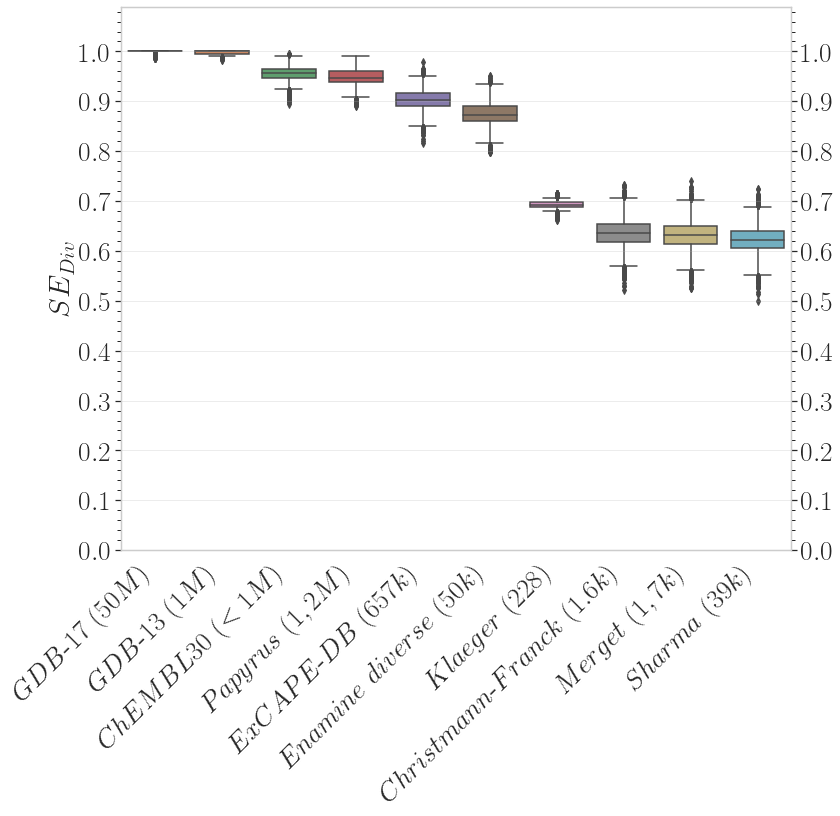

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
g = sns.boxplot(x='set', y='ratio', data=diversities_228,
                order=['GDB17', 'GDB13', 'ChEMBL', 'Papyrus', 'ExCAPE-DB',
                       'Enamine diverse (50k)', 'Klaeger',
                       'Christmann-Franck', 'Merget', 'Sharma'],
                ax=ax)
g.set_ylabel('$SE_{Div}$')
g.set_ylim(0, 1.09)
ymajorLocator = FixedLocator(locs=[x / 10 for x in range(11)])
yminorLocator = AutoMinorLocator(n=5)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
_ = ax.set_xticklabels(['$GDB$-$17$ $(50M)$', '$GDB$-$13$ $(1M)$',
                        '$ChEMBL30$ $(<1M)$', '$Papyrus$ $(1,2M)$',
                        '$ExCAPE$-$DB$ $(657k)$', '$Enamine$ $diverse$ $(50k)$',
                        '$Klaeger$ $(228)$', '$Christmann$-$Franck$ $(1.6k)$',
                        '$Merget$ $(1,7k)$', '$Sharma$ $(39k)$'],
                       rotation=45, ha="right")
_= g.set_xlabel('')

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
_ = ax2.set_yticks(ax.get_yticks())
ax2.yaxis.set_minor_locator(yminorLocator)

In [ ]:
fig.tight_layout()
fig.savefig('Diversity_228.svg')

In [ ]:
diversities_1500 = pd.concat([pd.read_csv(x, sep='\t')\
                             for x in ['Diversity_sphere_exclusion_1500.tsv',
                                       'Diversity_sphere_exclusion_Enamine_1500.tsv',
                                       'Diversity_sphere_exclusion_GDB13_1500.tsv',
                                       'Diversity_sphere_exclusion_GDB17_1500.tsv']])

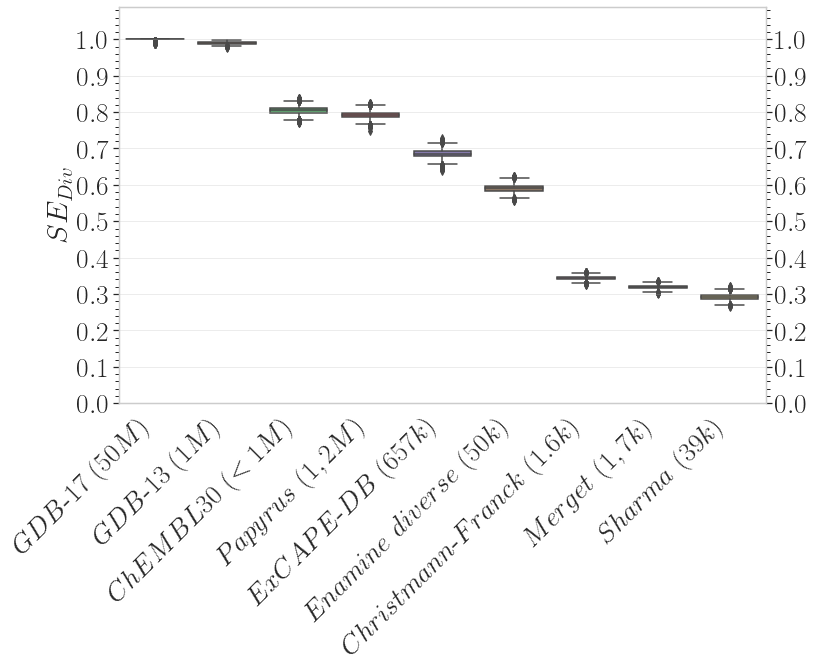

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 10))
g = sns.boxplot(x='set', y='ratio', data=diversities_1500,
                order=['GDB17', 'GDB13', 'ChEMBL', 'Papyrus', 'ExCAPE-DB',
                       'Enamine diverse (50k)',
                       'Christmann-Franck', 'Merget', 'Sharma'],
                ax=ax)
g.set_ylabel('$SE_{Div}$')
g.set_ylim(0, 1.09)
ymajorLocator = FixedLocator(locs=[x / 10 for x in range(11)])
yminorLocator = AutoMinorLocator(n=5)
ax.yaxis.set_major_locator(ymajorLocator)
ax.yaxis.set_minor_locator(yminorLocator)
_ = ax.set_xticklabels(['$GDB$-$17$ $(50M)$', '$GDB$-$13$ $(1M)$',
                        '$ChEMBL30$ $(<1M)$', '$Papyrus$ $(1,2M)$',
                        '$ExCAPE$-$DB$ $(657k)$', '$Enamine$ $diverse$ $(50k)$',
                        '$Christmann$-$Franck$ $(1.6k)$', '$Merget$ $(1,7k)$',
                        '$Sharma$ $(39k)$'],
                       rotation=45, ha="right")
_= g.set_xlabel('')

ax2 = ax.twinx()
ax2.set_ylim(ax.get_ylim())
_ = ax2.set_yticks(ax.get_yticks())
ax2.yaxis.set_minor_locator(yminorLocator)
fig.tight_layout()
fig.savefig('Diversity_1500.svg')